# Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Functions

In [ ]:
def plot_results_generic(np_data, models, objectives, lowest=0.5, is_sts=True):
  means = np.mean(np_data, axis=2)
  stds = np.std(np_data, axis=2)
  plt.figure(figsize=(16, 10))

  for i, obj in enumerate(objectives):
      if i == 0:
          plt.plot(models, means[:, i], label=obj, linestyle=':')
      elif i == 1:
          plt.plot(models, means[:, i], label=obj, linestyle='--')
      else:
          plt.plot(models, means[:, i], label=obj)
      # plt.fill_between(models, means[:, i] - stds[:, i], means[:, i] + stds[:, i], alpha=0.2)

  plt.title('Model Performance with respect to Loss Functions')
  if is_sts:
      plt.ylabel('Spearman\'s Rank Correlation Coefficient')
  else:
      plt.ylabel('Accuracy')
  plt.ylim((lowest, 1))
  plt.xlabel('Models')
  plt.xticks(rotation=45)
  plt.legend(title='Loss Functions')
  plt.tight_layout()
  plt.show()

In [ ]:
def plot_model_obj(df):
  mean_accuracy = df.groupby(['Model', 'Loss']).mean().unstack(level=-1)
  std_accuracy = df.groupby(['Model', 'Loss']).std().unstack(level=-1)

  objectives = df.index.get_level_values('Loss').unique()
  fig, axes = plt.subplots(nrows=1, ncols=len(objectives), figsize=(30, 5), sharey=True)

  if len(objectives) == 1:
      axes = [axes]

  for i, objective in enumerate(objectives):
      ax = axes[i]
      mean_values = mean_accuracy['Accuracy'][objective]
      std_values = std_accuracy['Accuracy'][objective]
      models = mean_values.index

      ax.plot(models, mean_values, label='Mean Accuracy')
      ax.fill_between(models, mean_values - std_values, mean_values + std_values, alpha=0.2)
      ax.set_title(f'{objective}',fontsize=20)
      ax.tick_params(axis='both', which='major', labelsize=14)
      ax.tick_params(axis='x', rotation=90)

  plt.tight_layout()
  plt.show()

In [ ]:
def plot_model_dataset(df, models, dataset_count=4):
  df_reset = df.reset_index()
  df_mean = df_reset.groupby(['Model', 'Dataset'])['Accuracy'].mean().unstack()
  df_std = df_reset.groupby(['Model', 'Dataset'])['Accuracy'].std().unstack()

  fig, axes = plt.subplots(nrows=1, ncols=dataset_count,figsize=(40, 5), sharey=True)
  axes = axes.flatten()

  for i, dataset in enumerate(df_mean.columns):
      ax = axes[i]
      df_mean[dataset].plot(ax=ax, legend=False)
      ax.fill_between(df_mean.index, (df_mean[dataset] - df_std[dataset]).values, (df_mean[dataset] + df_std[dataset]).values, alpha=0.2)
      ax.set_title(dataset,fontsize=20)
      ax.set_xlabel('')
      ax.set_xticks(range(len(models)))
      ax.tick_params(axis='both', which='major', labelsize=18)
      ax.set_xticklabels(models, rotation=90, ha="right")

  plt.show()

In [ ]:
def plot_datasets_obj(df):
  grouped = df.groupby(['Loss', 'Dataset'])['Accuracy'].agg(['mean', 'std'])
  objectives = df.index.get_level_values('Loss').unique()
  fig, axs = plt.subplots(nrows=1, ncols=len(objectives), figsize=(40, 5), sharey=True)

  for ax, objective in zip(axs, objectives):
      objective_data = grouped.loc[objective]
      ax.plot(objective_data.index, objective_data['mean'], label='Mean Accuracy')
      ax.fill_between(objective_data.index,
                      objective_data['mean'] - objective_data['std'],
                      objective_data['mean'] + objective_data['std'],
                      alpha=0.2, label='Std Dev')

      ax.set_title(f'{objective}',fontsize=20)
      ax.tick_params(axis='x', rotation=45)
      ax.tick_params(axis='both', which='major', labelsize=18)

  plt.tight_layout()
  plt.show()

In [ ]:
def plot_datasets_obj_line(df):
  df_reset = df.reset_index()
  unique_objectives = df_reset['Loss'].unique()

  fig, axes = plt.subplots(nrows=1, ncols=len(unique_objectives), figsize=(40, 5), sharey=True)
  fig.subplots_adjust(hspace=0.3, wspace=0.2)
  axes = axes.flatten()

  handles, labels = [], []
  for i, objective in enumerate(unique_objectives):
      ax = axes[i]
      df_filtered = df_reset[df_reset['Loss'] == objective]
      df_pivot = df_filtered.pivot_table(index='Dataset', columns='Model', values='Accuracy')

      for model in df_pivot.columns:
          data = df_pivot[model]
          (line,) = ax.plot(data.index, data, marker='o', markersize=8, label=model, linewidth=3)

          if i == 0:
              handles.append(line)
              labels.append(model)

      ax.set_title(f'{objective}', fontsize=20)
      ax.grid(True)
      ax.set_xlabel('')
      ax.tick_params(axis='x', rotation=45)
      ax.tick_params(axis='both', which='major', labelsize=20)

  for ax in axes:
      ax.legend().set_visible(False)

  fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.07, 0.9), ncol=1, fontsize=12)
  plt.tight_layout()
  plt.show()

In [ ]:
def get_df(array, models, objectives, datasets):
  multi_index = pd.MultiIndex.from_product([models, objectives, datasets], names=["Model", "Loss", "Dataset"])
  flattened_data = array.reshape(-1)
  df = pd.DataFrame(flattened_data, index=multi_index, columns=["Accuracy"])
  return df

# Generate Plots

In [ ]:
array_senteval = np.load('BERT_SentEval_Results_Default.npy')
array_sts = np.load('BERT_STS_Results_Default1.npy')

In [ ]:
models = ['BERT-BASE-UNCASED', 'BERT-BASE-CASED', 'BERT-LARGE-UNCASED', 'BERT-LARGE-CASED', 'ROBERTA-BASE', 'SBERT', 'SimCSE-ROBERTA-LARGE']
objectives = [
    'Without Fine-Tuning',
    'Default Cosine Similarity Loss',
    'CoSENT Loss',
    'In-Batch Negatives Loss',
    'Angle Loss',
    'CoSENT + IBN Losses',
    'CoSENT + Angle Losses',
    'IBN + Angle Losses',
    'CoSENT + IBN + Angle Losses']
datasets_senteval = ['CR', 'MPQA', 'MR', 'SUBJ']
datasets_sts = ['STS-B', 'STS12', 'STS13', 'STS14', 'STS15', 'STS16', 'SICK-R']

### Generating Tables for SentEval

In [ ]:
dfs_senteval = {}
for i, dataset in enumerate(datasets_senteval):
    df = pd.DataFrame(array_senteval[:, :, i], index=models, columns=objectives)
    dfs_senteval[dataset] = df

### Generating Tables for STS

In [ ]:
dfs_sts = {}
for i, dataset in enumerate(datasets_sts):
    df = pd.DataFrame(array_sts[:, :, i], index=models, columns=objectives)
    dfs_sts[dataset] = df

# SentEval Plots

In [ ]:
df_senteval = get_df(array_senteval, models, objectives, datasets_senteval)

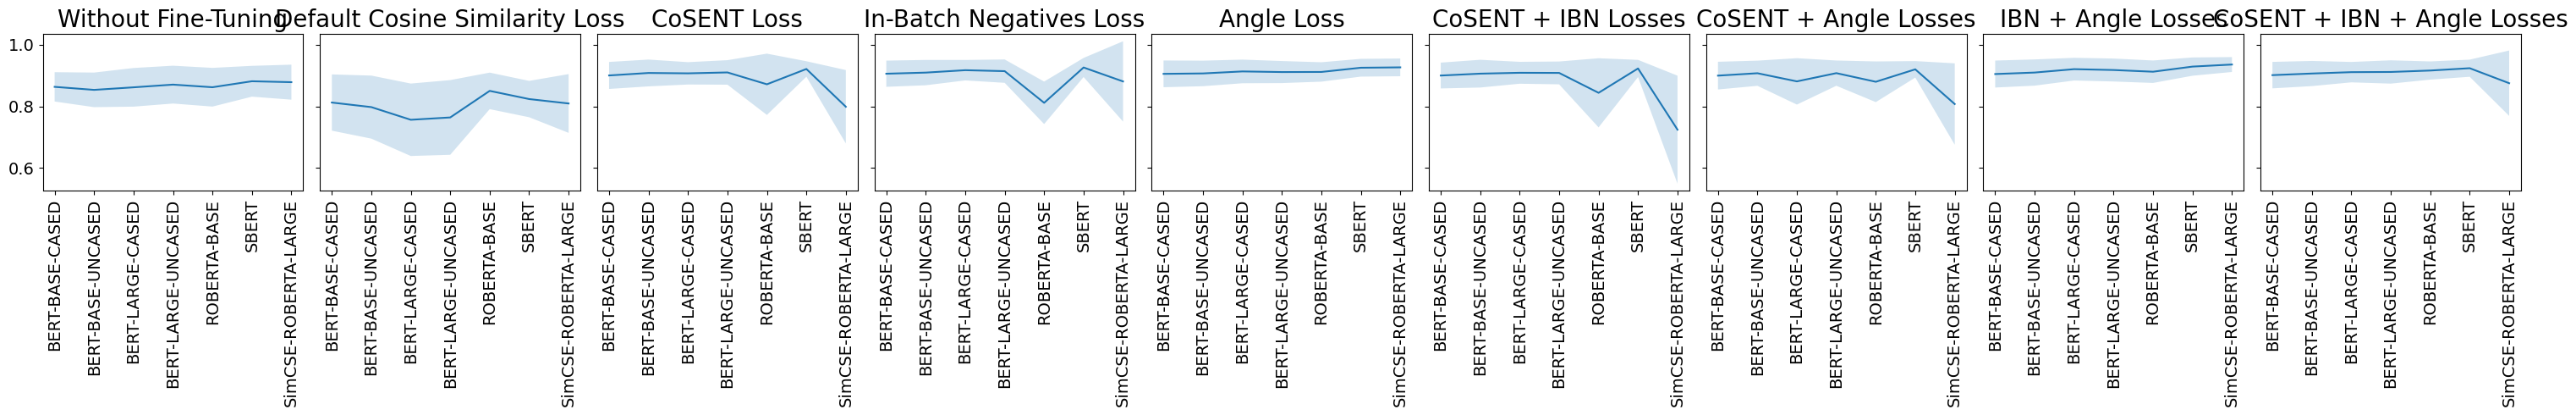

In [ ]:
plot_model_obj(df_senteval)

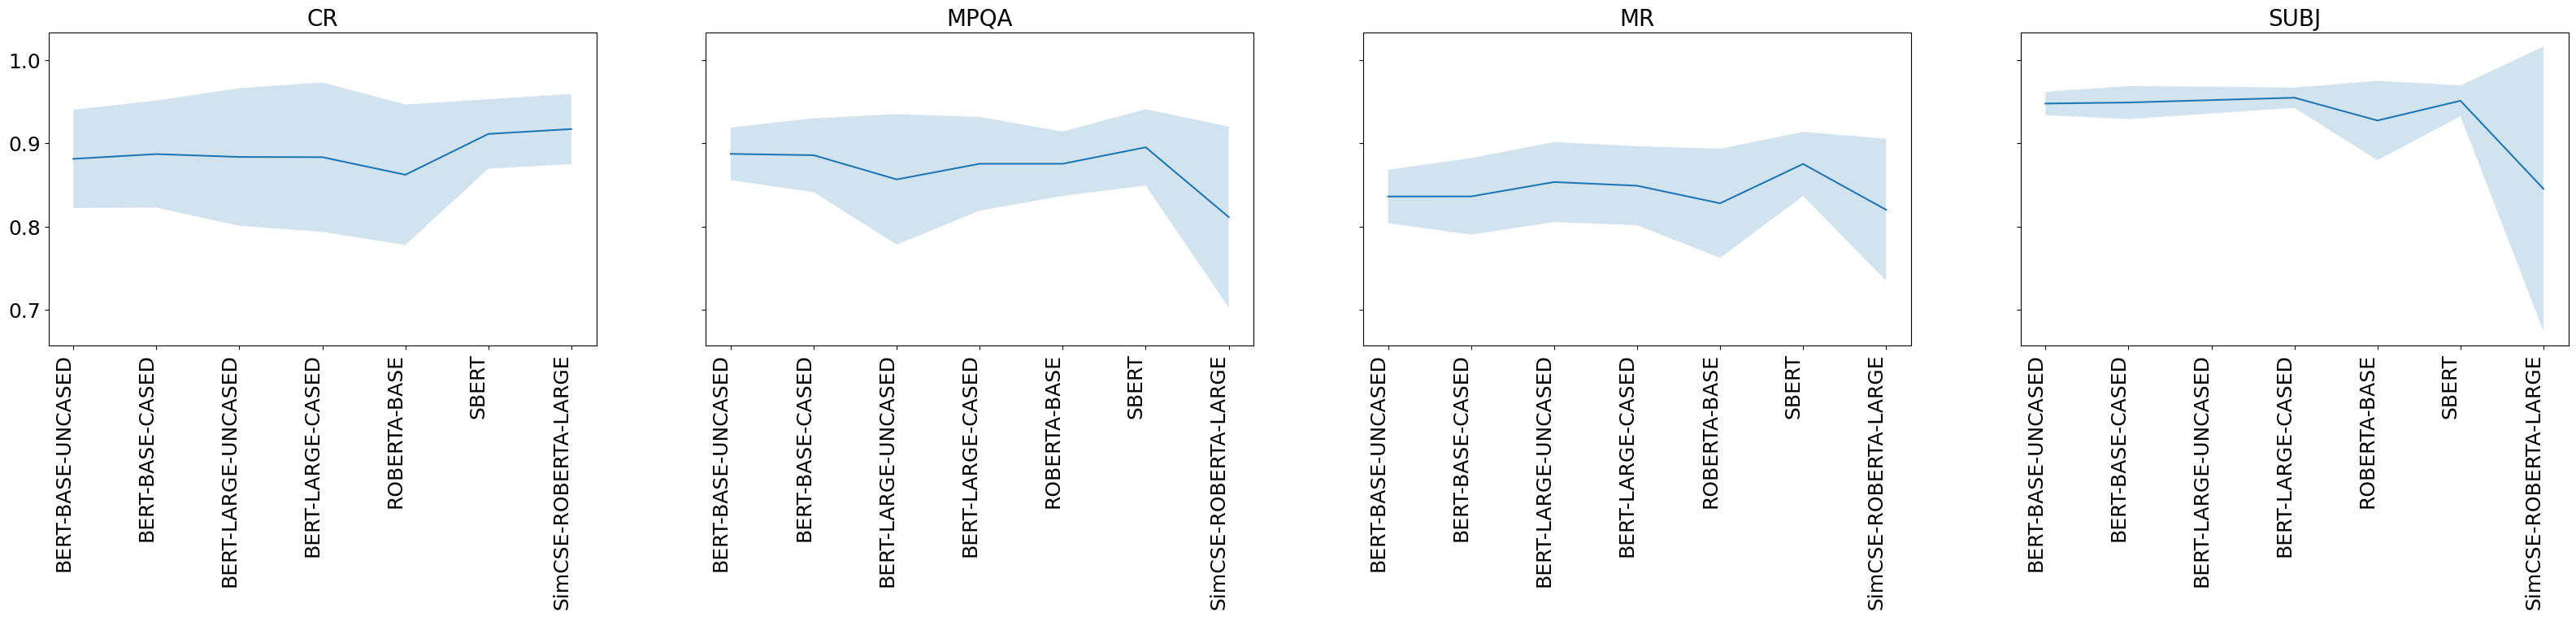

In [ ]:
plot_model_dataset(df_senteval, models)

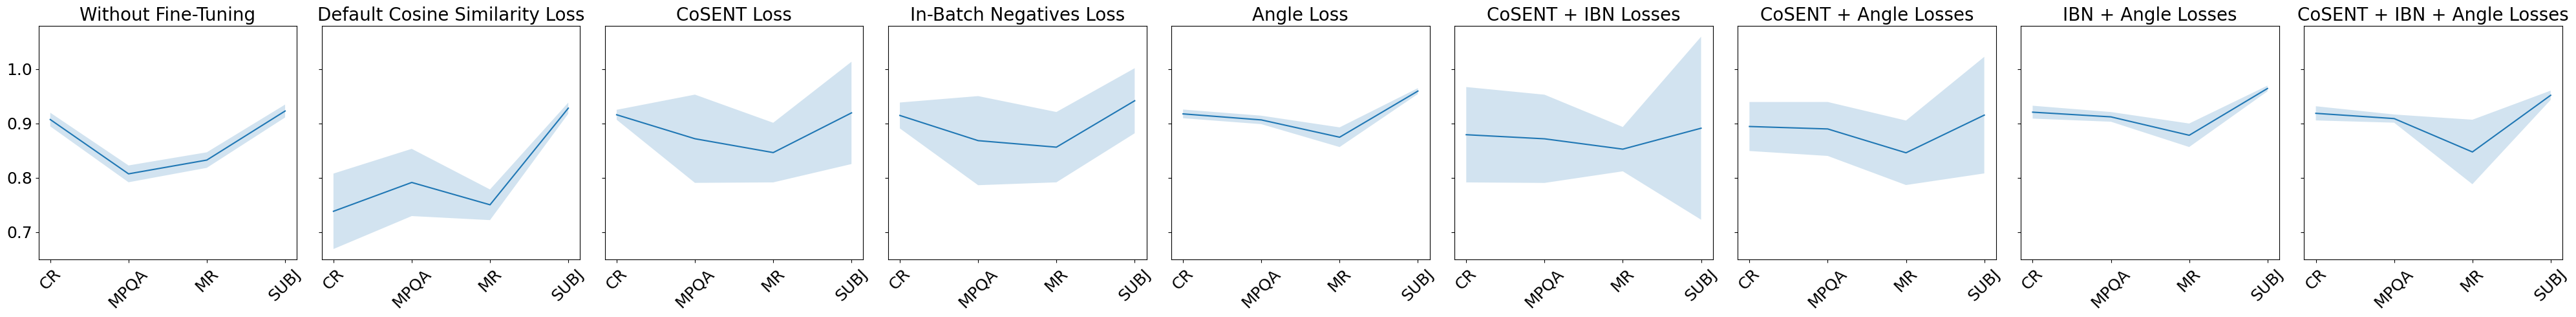

In [ ]:
plot_datasets_obj(df_senteval)

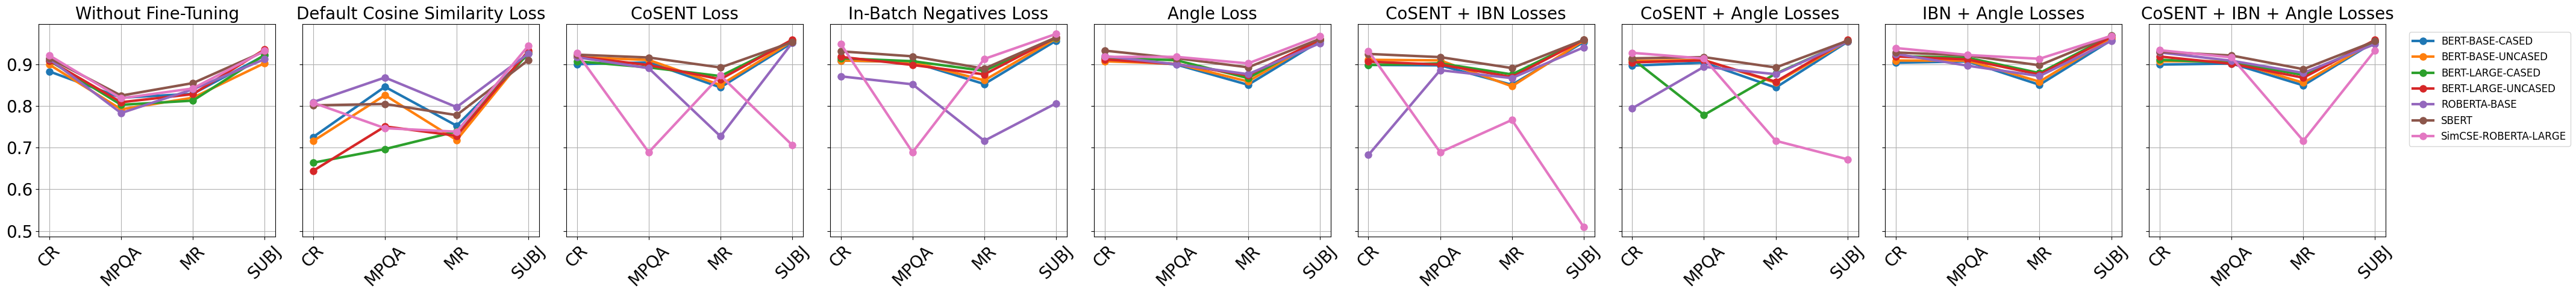

In [ ]:
plot_datasets_obj_line(df_senteval)

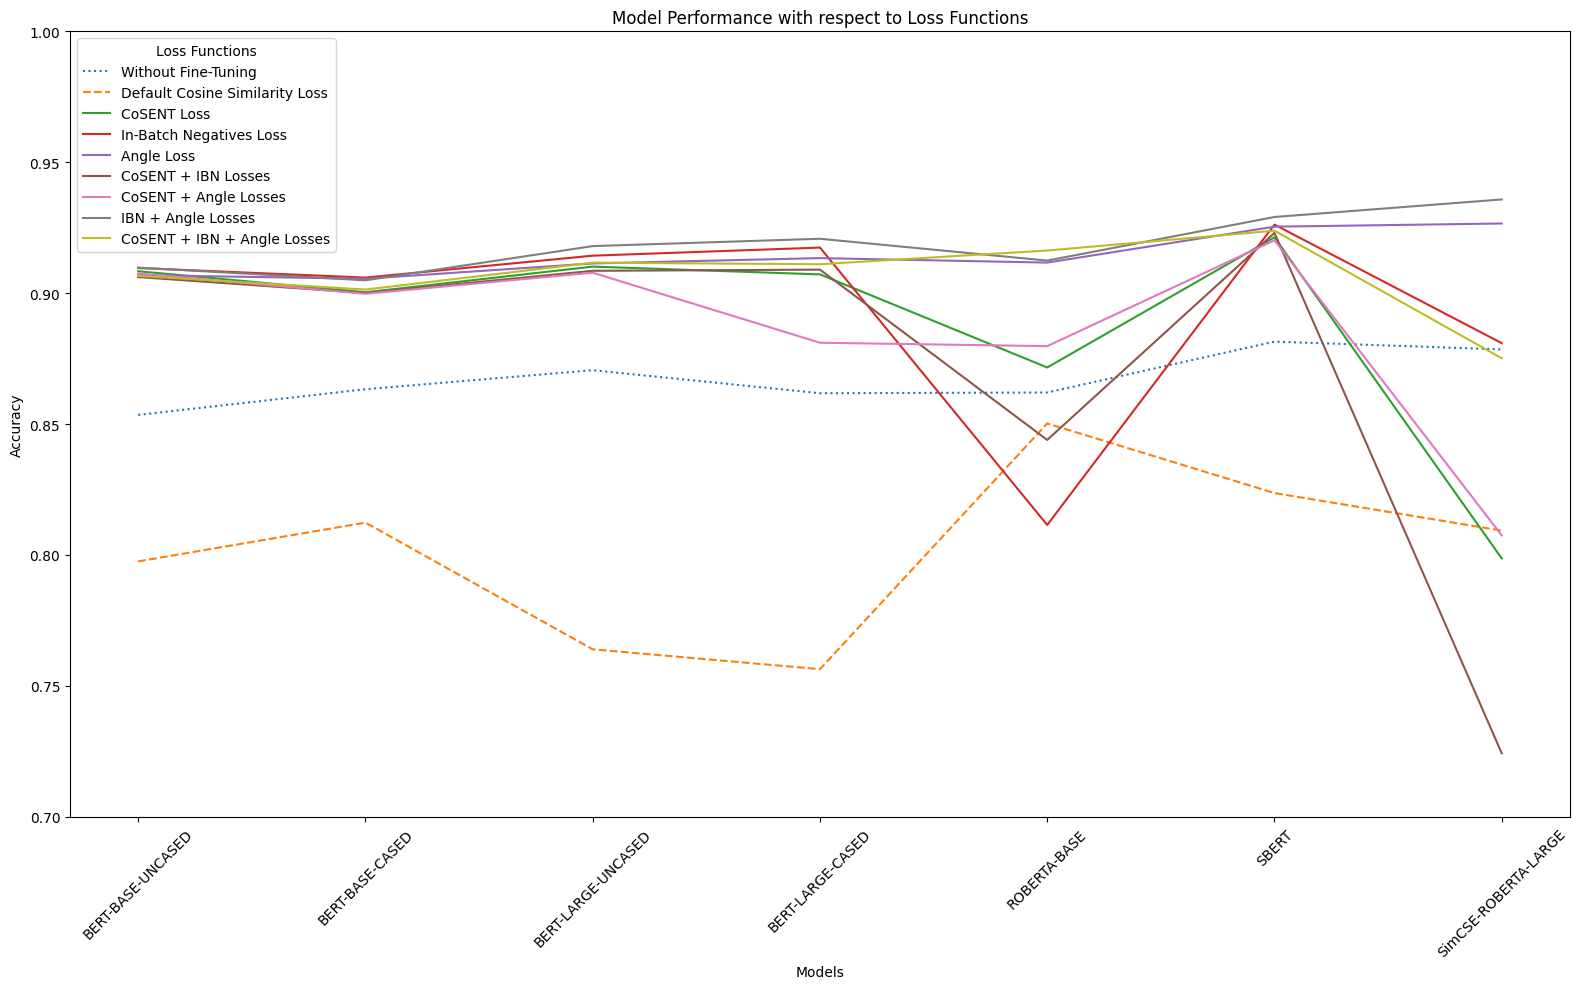

In [ ]:
plot_results_generic(array_senteval, models, objectives, lowest=0.7, is_sts=False)

# STS Plots

In [ ]:
df_sts = get_df(array_sts, models, objectives, datasets_sts)

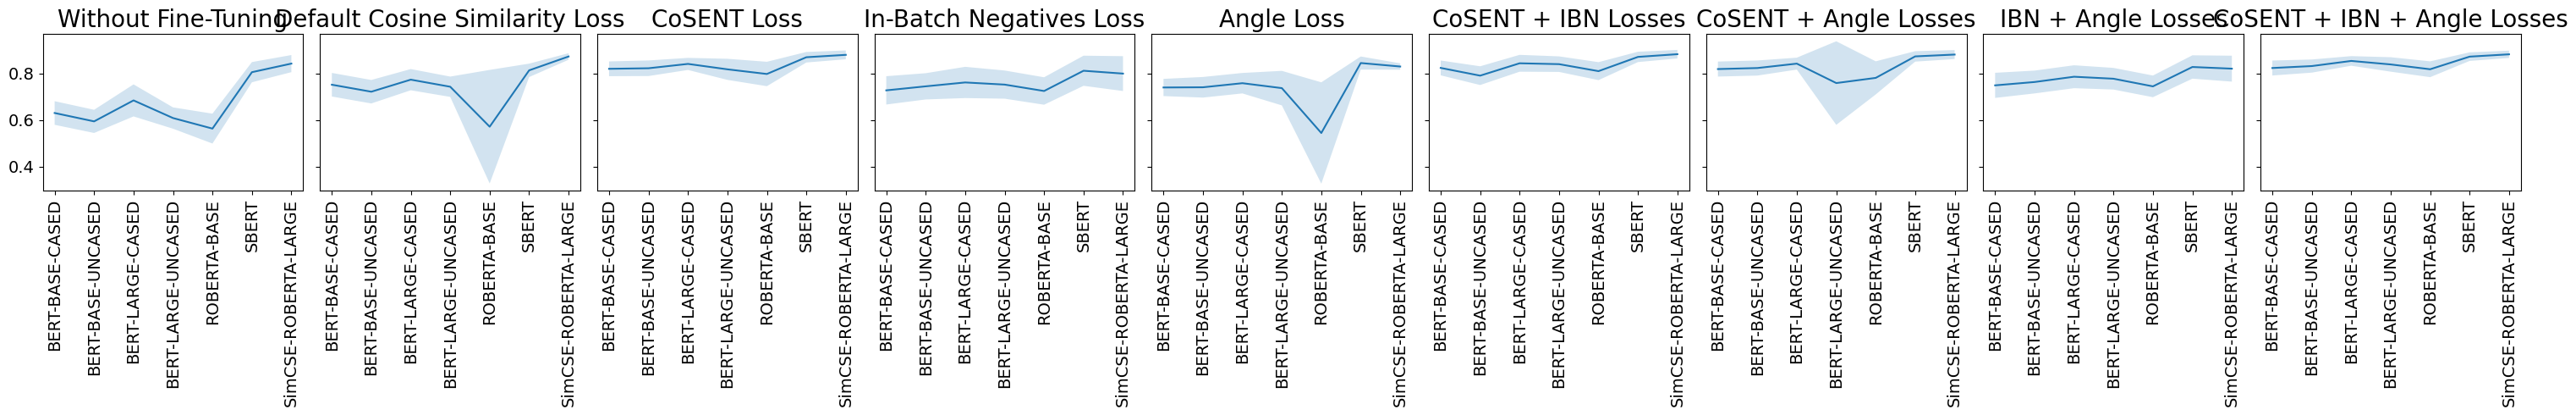

In [ ]:
plot_model_obj(df_sts)

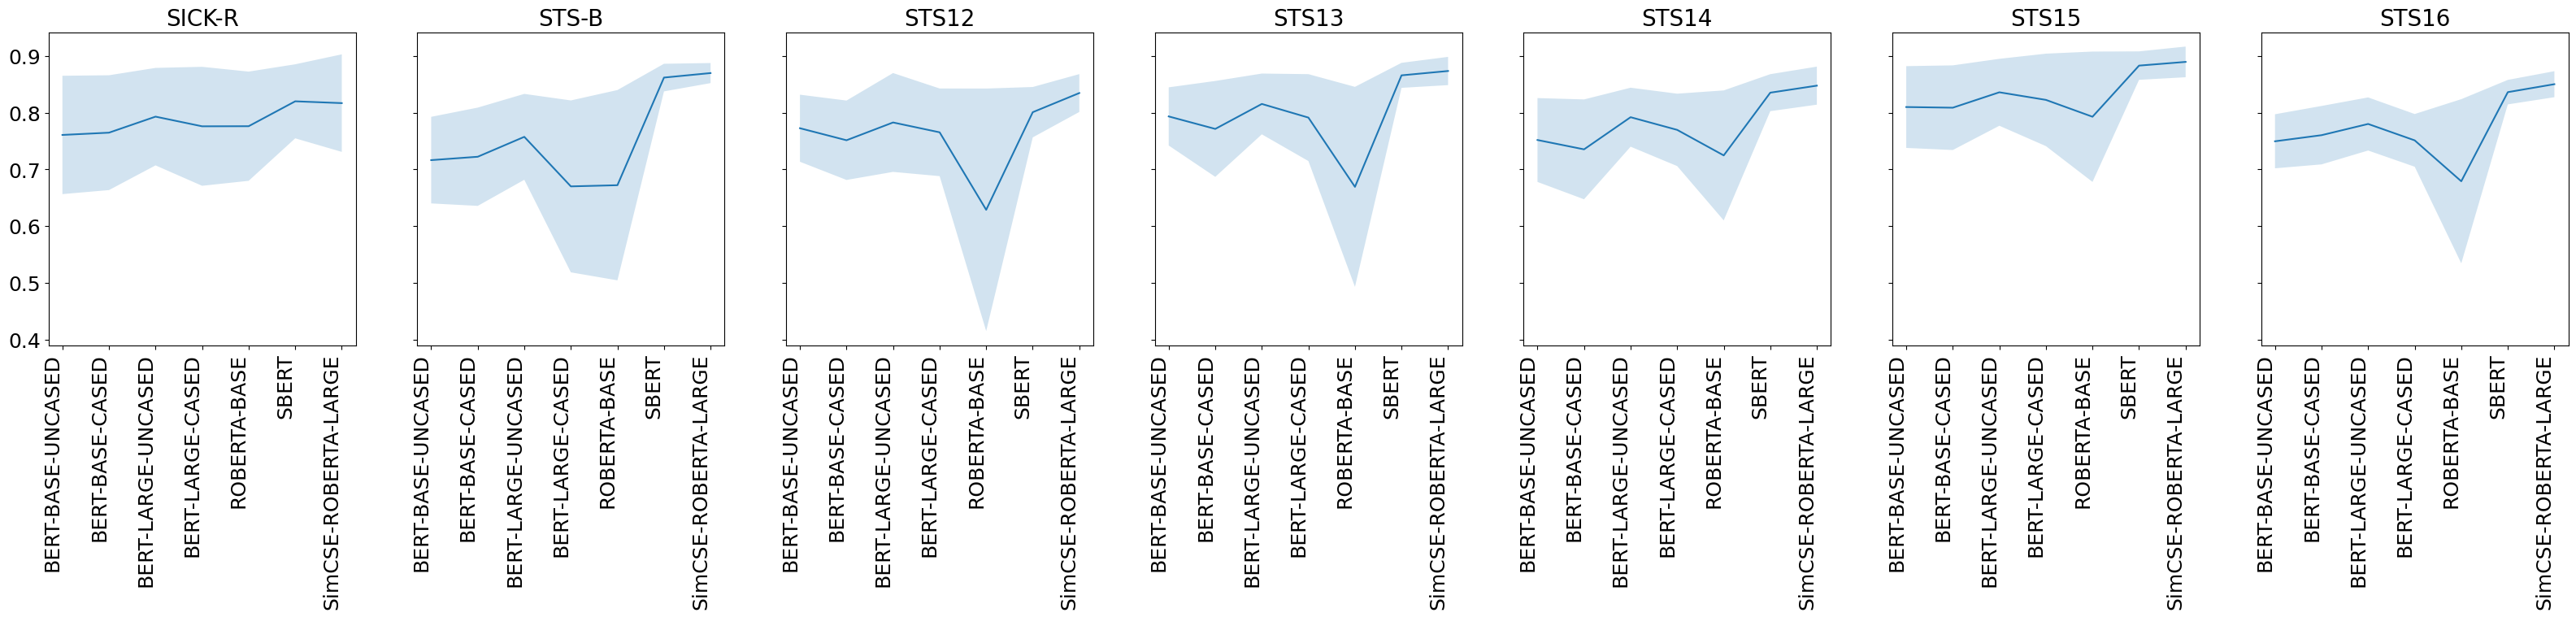

In [ ]:
plot_model_dataset(df_sts, models, dataset_count=7)

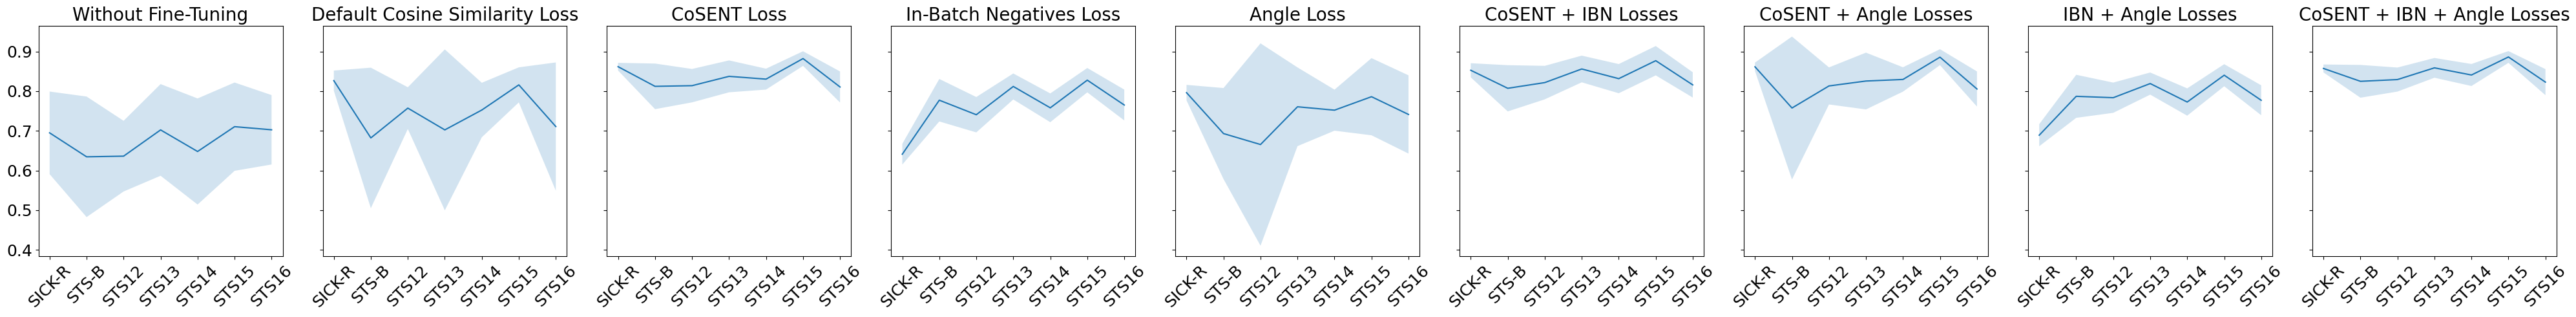

In [ ]:
plot_datasets_obj(df_sts)

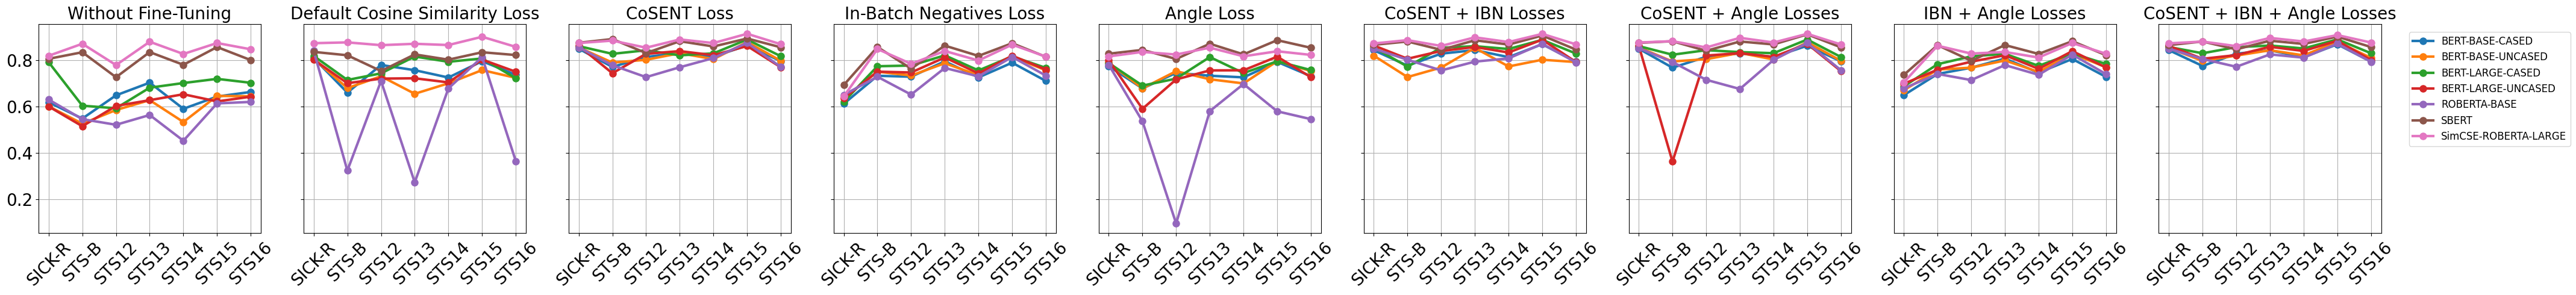

In [ ]:
plot_datasets_obj_line(df_sts)

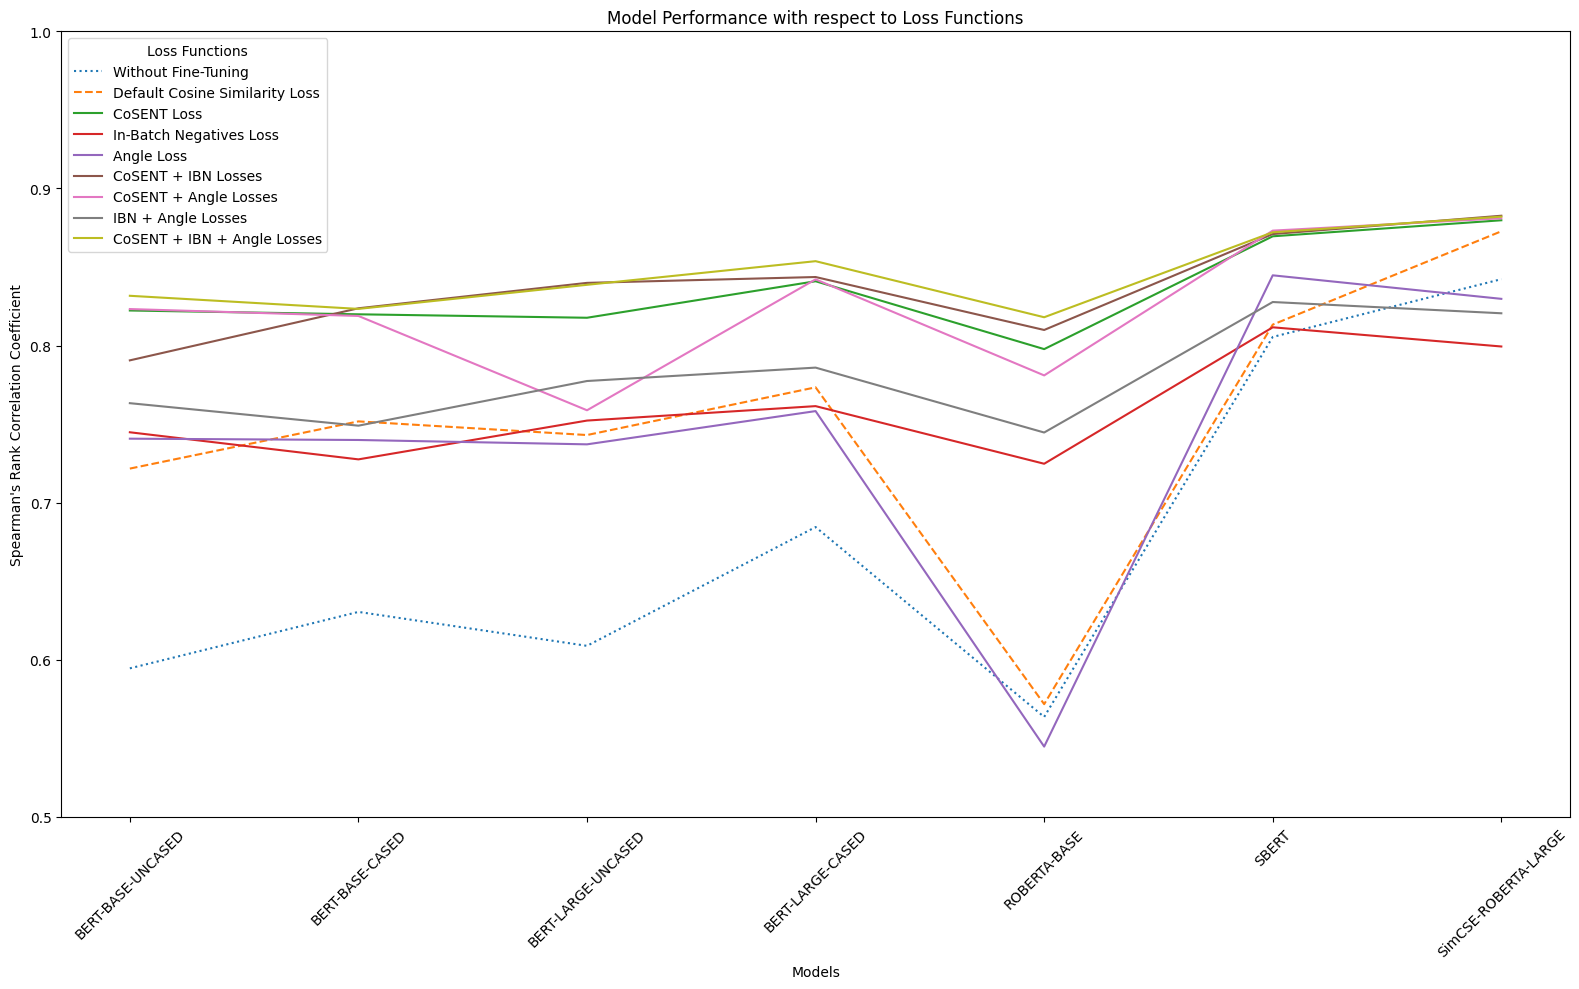

In [ ]:
plot_results_generic(array_sts, models, objectives, lowest=0.5)

### Pairwise Comparison - STS

In [ ]:
model_wise_df = []

for i in range(len(models)):
    df = pd.DataFrame(array_sts[i])
    df.columns = datasets_sts
    df.index = objectives
    model_wise_df.append({'model': models[i], 'data': df})

#### No FT vs Default Pairwise Cosine Similarity Loss

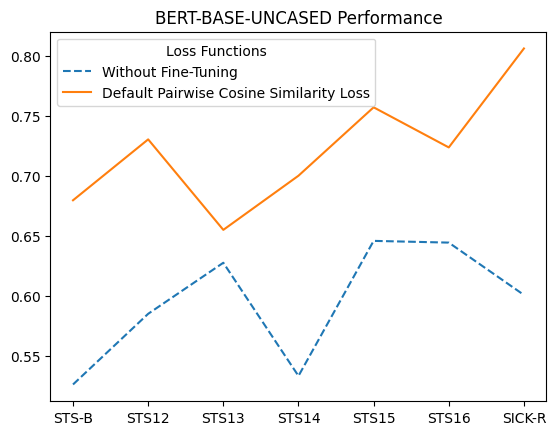

In [ ]:
# BERT-BASE-UNCASED...
plt.plot(datasets_sts, model_wise_df[0]['data'].iloc[0], '--', label='Without Fine-Tuning')
plt.plot(datasets_sts, model_wise_df[0]['data'].iloc[1], label='Default Pairwise Cosine Similarity Loss')
plt.legend(title='Loss Functions')
plt.title('BERT-BASE-UNCASED Performance')
plt.show()

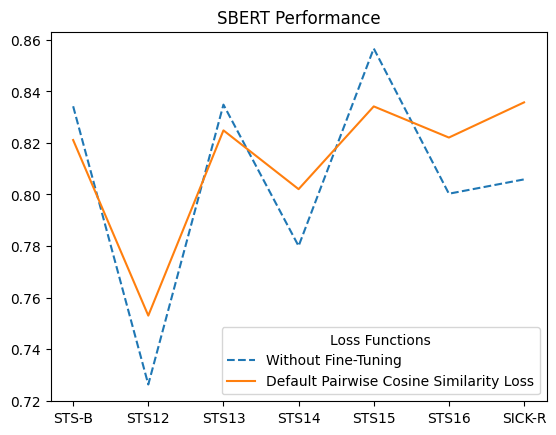

In [ ]:
# SBERT...
plt.plot(datasets_sts, model_wise_df[5]['data'].iloc[0], '--', label='Without Fine-Tuning')
plt.plot(datasets_sts, model_wise_df[5]['data'].iloc[1], label='Default Pairwise Cosine Similarity Loss')
plt.legend(title='Loss Functions')
plt.title('SBERT Performance')
plt.show()

#### CoSENT Loss Comparison

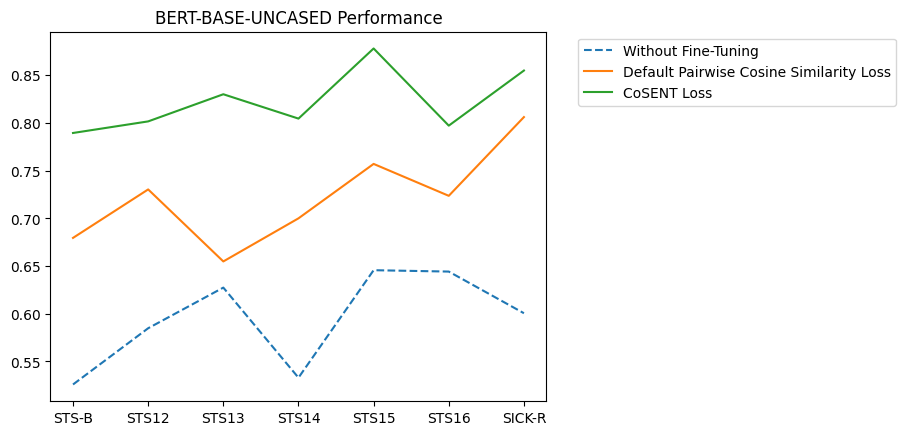

In [ ]:
# BERT-BASE-UNCASED...
plt.plot(datasets_sts, model_wise_df[0]['data'].iloc[0], '--', label='Without Fine-Tuning')
plt.plot(datasets_sts, model_wise_df[0]['data'].iloc[1], label='Default Pairwise Cosine Similarity Loss')
plt.plot(datasets_sts, model_wise_df[0]['data'].iloc[2], label='CoSENT Loss')
plt.legend(title='Loss Functions')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('BERT-BASE-UNCASED Performance')
plt.show()

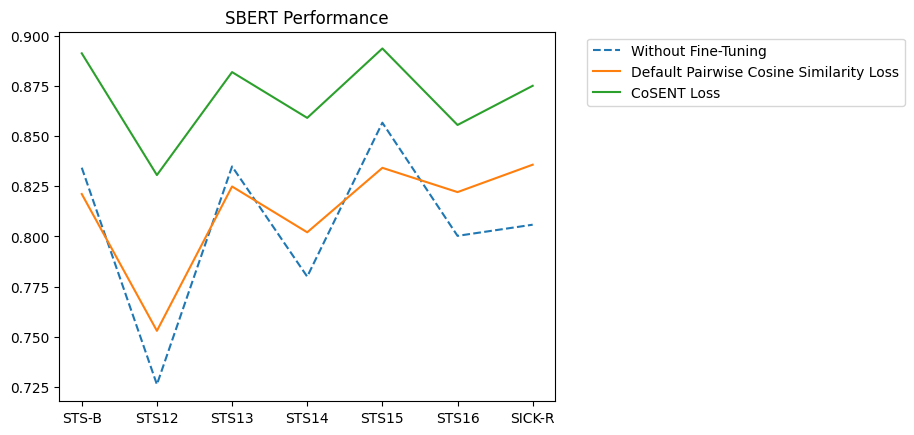

In [ ]:
# SBERT...
plt.plot(datasets_sts, model_wise_df[5]['data'].iloc[0], '--', label='Without Fine-Tuning')
plt.plot(datasets_sts, model_wise_df[5]['data'].iloc[1], label='Default Pairwise Cosine Similarity Loss')
plt.plot(datasets_sts, model_wise_df[5]['data'].iloc[2], label='CoSENT Loss')
plt.legend(title='Loss Functions')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('SBERT Performance')
plt.show()

#### In-Batch Negatives Comparison

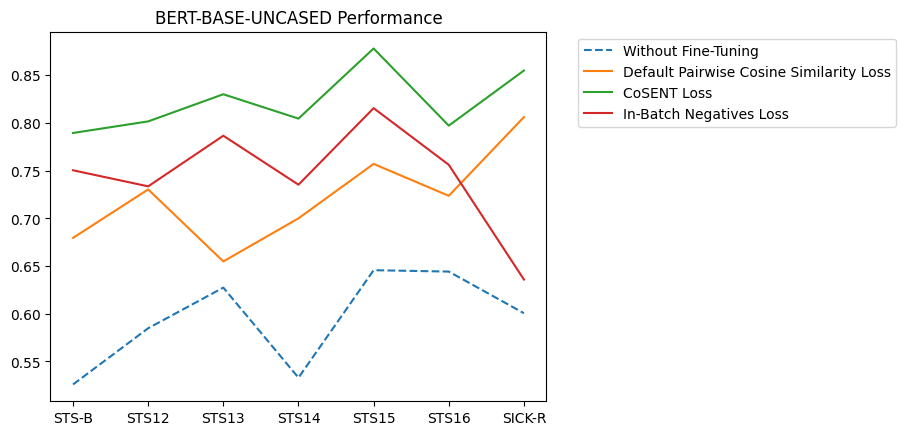

In [ ]:
# BERT-BASE-UNCASED...
plt.plot(datasets_sts, model_wise_df[0]['data'].iloc[0], '--', label='Without Fine-Tuning')
plt.plot(datasets_sts, model_wise_df[0]['data'].iloc[1], label='Default Pairwise Cosine Similarity Loss')
plt.plot(datasets_sts, model_wise_df[0]['data'].iloc[2], label='CoSENT Loss')
plt.plot(datasets_sts, model_wise_df[0]['data'].iloc[3], label='In-Batch Negatives Loss')
plt.legend(title='Loss Functions')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('BERT-BASE-UNCASED Performance')
plt.show()

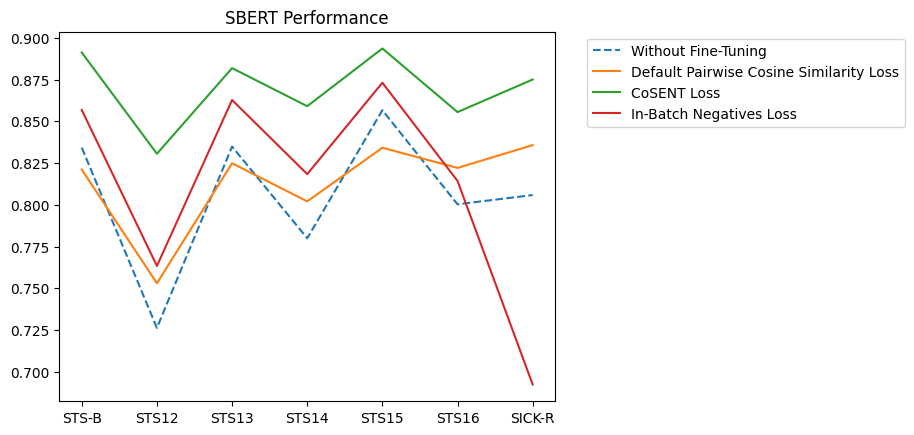

In [ ]:
# SBERT...
plt.plot(datasets_sts, model_wise_df[5]['data'].iloc[0], '--', label='Without Fine-Tuning')
plt.plot(datasets_sts, model_wise_df[5]['data'].iloc[1], label='Default Pairwise Cosine Similarity Loss')
plt.plot(datasets_sts, model_wise_df[5]['data'].iloc[2], label='CoSENT Loss')
plt.plot(datasets_sts, model_wise_df[5]['data'].iloc[3], label='In-Batch Negatives Loss')
plt.legend(title='Loss Functions')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('SBERT Performance')
plt.show()

#### CoSENT and In-Batch Negatives Loss Combination

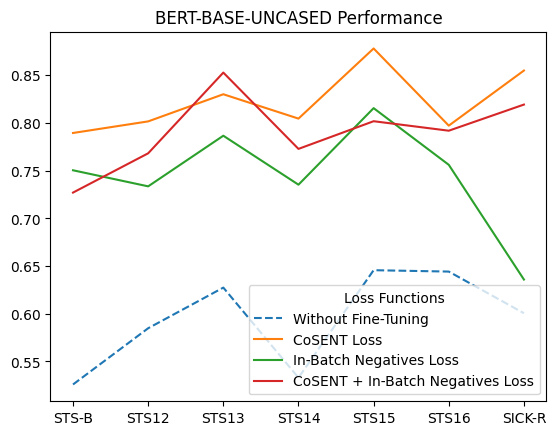

In [ ]:
# BERT-BASE-UNCASED...
plt.plot(datasets_sts, model_wise_df[0]['data'].iloc[0], '--', label='Without Fine-Tuning')
plt.plot(datasets_sts, model_wise_df[0]['data'].iloc[2], label='CoSENT Loss')
plt.plot(datasets_sts, model_wise_df[0]['data'].iloc[3], label='In-Batch Negatives Loss')
plt.plot(datasets_sts, model_wise_df[0]['data'].iloc[5], label='CoSENT + In-Batch Negatives Loss')
plt.legend(title='Loss Functions')
plt.title('BERT-BASE-UNCASED Performance')
plt.show()

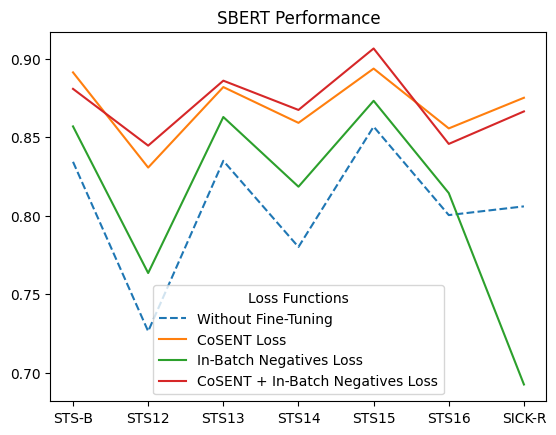

In [ ]:
# SBERT...
plt.plot(datasets_sts, model_wise_df[5]['data'].iloc[0], '--', label='Without Fine-Tuning')
plt.plot(datasets_sts, model_wise_df[5]['data'].iloc[2], label='CoSENT Loss')
plt.plot(datasets_sts, model_wise_df[5]['data'].iloc[3], label='In-Batch Negatives Loss')
plt.plot(datasets_sts, model_wise_df[5]['data'].iloc[5], label='CoSENT + In-Batch Negatives Loss')
plt.legend(title='Loss Functions')
plt.title('SBERT Performance')
plt.show()

#### Angle Comparison

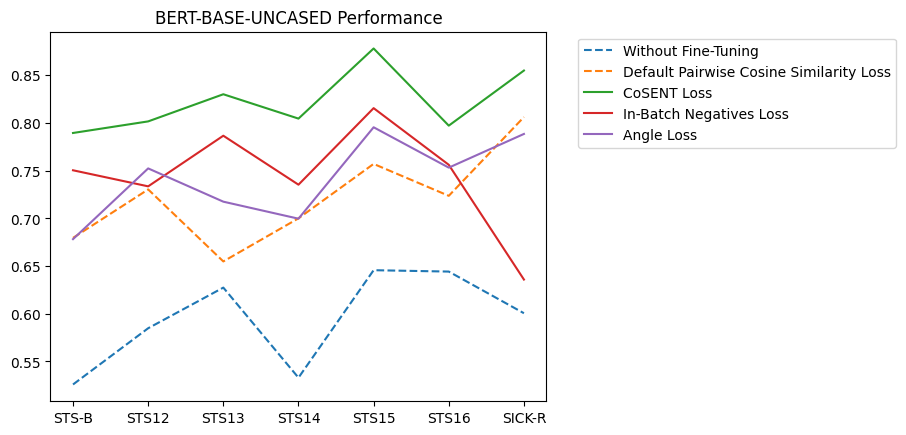

In [ ]:
# BERT-BASE-UNCASED...
plt.plot(datasets_sts, model_wise_df[0]['data'].iloc[0], '--', label='Without Fine-Tuning')
plt.plot(datasets_sts, model_wise_df[0]['data'].iloc[1], '--', label='Default Pairwise Cosine Similarity Loss')
plt.plot(datasets_sts, model_wise_df[0]['data'].iloc[2], label='CoSENT Loss')
plt.plot(datasets_sts, model_wise_df[0]['data'].iloc[3], label='In-Batch Negatives Loss')
plt.plot(datasets_sts, model_wise_df[0]['data'].iloc[4], label='Angle Loss')
plt.legend(title='Loss Functions')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('BERT-BASE-UNCASED Performance')
plt.show()

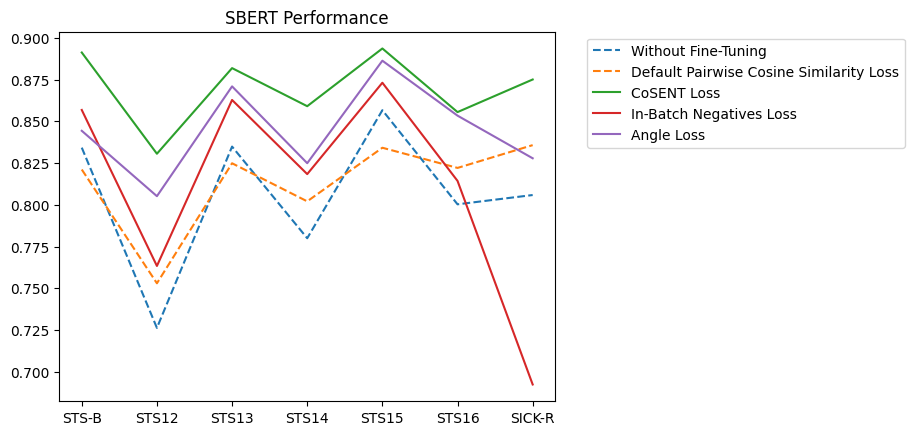

In [ ]:
# SBERT...
plt.plot(datasets_sts, model_wise_df[5]['data'].iloc[0], '--', label='Without Fine-Tuning')
plt.plot(datasets_sts, model_wise_df[5]['data'].iloc[1], '--', label='Default Pairwise Cosine Similarity Loss')
plt.plot(datasets_sts, model_wise_df[5]['data'].iloc[2], label='CoSENT Loss')
plt.plot(datasets_sts, model_wise_df[5]['data'].iloc[3], label='In-Batch Negatives Loss')
plt.plot(datasets_sts, model_wise_df[5]['data'].iloc[4], label='Angle Loss')
plt.legend(title='Loss Functions')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('SBERT Performance')
plt.show()

#### Angle Combination

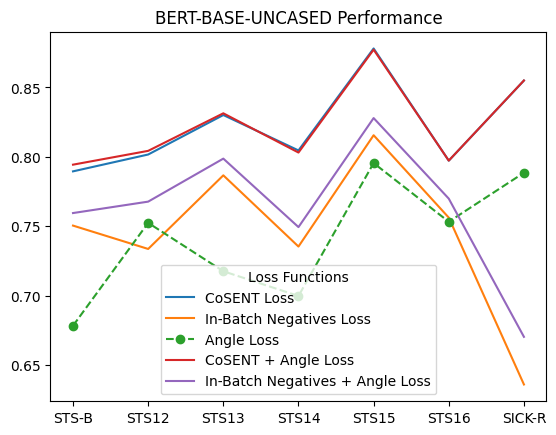

In [ ]:
# BERT-BASE-UNCASED...
plt.plot(datasets_sts, model_wise_df[0]['data'].iloc[2], label='CoSENT Loss')
plt.plot(datasets_sts, model_wise_df[0]['data'].iloc[3], label='In-Batch Negatives Loss')
plt.plot(datasets_sts, model_wise_df[0]['data'].iloc[4], 'o--', label='Angle Loss')
plt.plot(datasets_sts, model_wise_df[0]['data'].iloc[6], label='CoSENT + Angle Loss')
plt.plot(datasets_sts, model_wise_df[0]['data'].iloc[7], label='In-Batch Negatives + Angle Loss')
plt.legend(title='Loss Functions')
plt.title('BERT-BASE-UNCASED Performance')
plt.show()

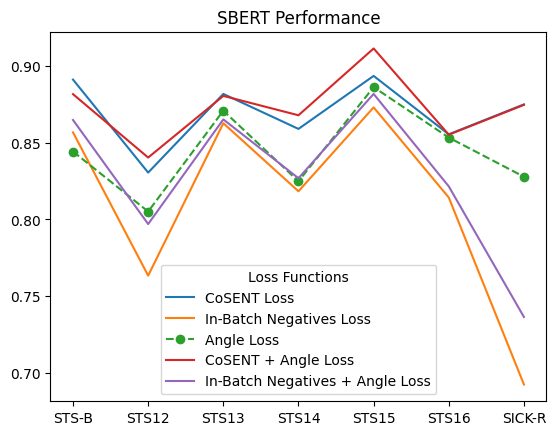

In [ ]:
# SBERT...
plt.plot(datasets_sts, model_wise_df[5]['data'].iloc[2], label='CoSENT Loss')
plt.plot(datasets_sts, model_wise_df[5]['data'].iloc[3], label='In-Batch Negatives Loss')
plt.plot(datasets_sts, model_wise_df[5]['data'].iloc[4], 'o--', label='Angle Loss')
plt.plot(datasets_sts, model_wise_df[5]['data'].iloc[6], label='CoSENT + Angle Loss')
plt.plot(datasets_sts, model_wise_df[5]['data'].iloc[7], label='In-Batch Negatives + Angle Loss')
plt.legend(title='Loss Functions')
plt.title('SBERT Performance')
plt.show()

#### All Combinations

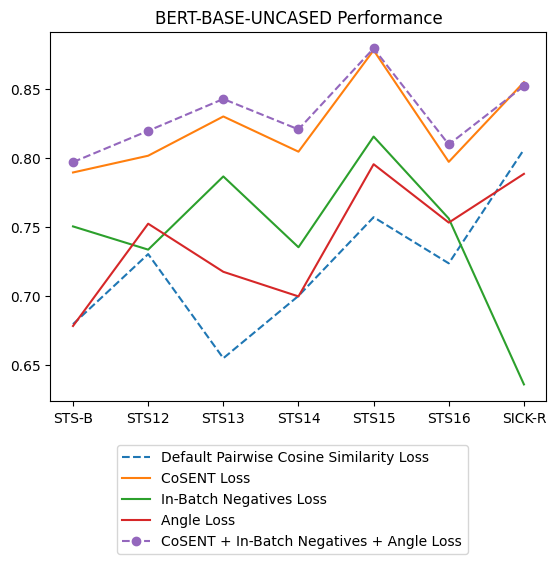

In [ ]:
# BERT-BASE-UNCASED...
plt.plot(datasets_sts, model_wise_df[0]['data'].iloc[1], '--', label='Default Pairwise Cosine Similarity Loss')
plt.plot(datasets_sts, model_wise_df[0]['data'].iloc[2], label='CoSENT Loss')
plt.plot(datasets_sts, model_wise_df[0]['data'].iloc[3], label='In-Batch Negatives Loss')
plt.plot(datasets_sts, model_wise_df[0]['data'].iloc[4], label='Angle Loss')
plt.plot(datasets_sts, model_wise_df[0]['data'].iloc[8], 'o--', label='CoSENT + In-Batch Negatives + Angle Loss')
plt.legend(title='Loss Functions')
plt.legend(bbox_to_anchor=(0.12, -0.1), loc='upper left')
plt.title('BERT-BASE-UNCASED Performance')
plt.show()

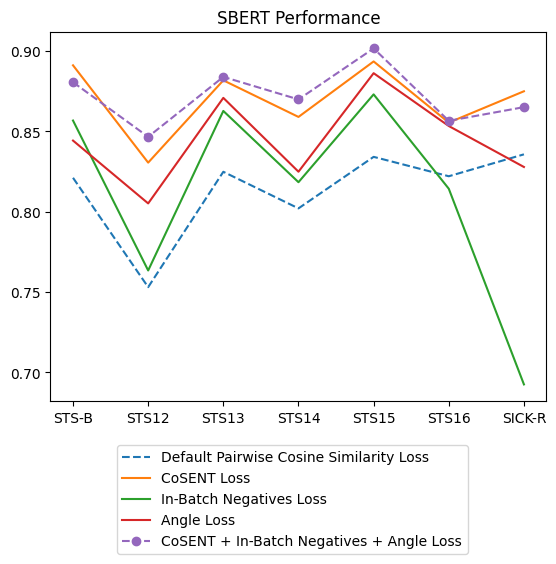

In [ ]:
# SBERT...
plt.plot(datasets_sts, model_wise_df[5]['data'].iloc[1], '--', label='Default Pairwise Cosine Similarity Loss')
plt.plot(datasets_sts, model_wise_df[5]['data'].iloc[2], label='CoSENT Loss')
plt.plot(datasets_sts, model_wise_df[5]['data'].iloc[3], label='In-Batch Negatives Loss')
plt.plot(datasets_sts, model_wise_df[5]['data'].iloc[4], label='Angle Loss')
plt.plot(datasets_sts, model_wise_df[5]['data'].iloc[8], 'o--', label='CoSENT + In-Batch Negatives + Angle Loss')
plt.legend(title='Loss Functions')
plt.legend(bbox_to_anchor=(0.12, -0.1), loc='upper left')
plt.title('SBERT Performance')
plt.show()

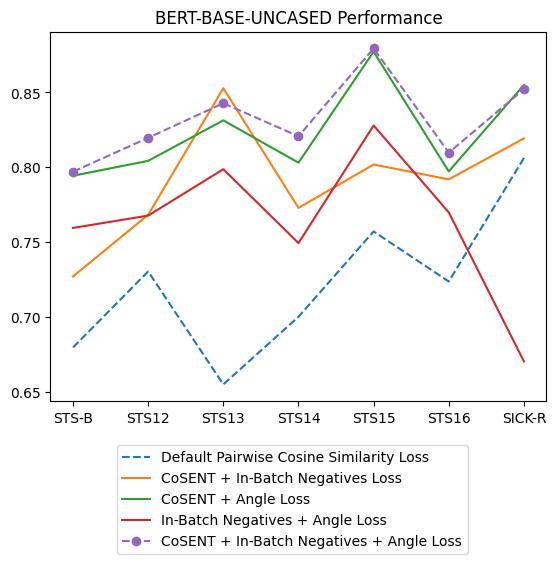

In [ ]:
# BERT-BASE-UNCASED...
plt.plot(datasets_sts, model_wise_df[0]['data'].iloc[1], '--', label='Default Pairwise Cosine Similarity Loss')
plt.plot(datasets_sts, model_wise_df[0]['data'].iloc[5], label='CoSENT + In-Batch Negatives Loss')
plt.plot(datasets_sts, model_wise_df[0]['data'].iloc[6], label='CoSENT + Angle Loss')
plt.plot(datasets_sts, model_wise_df[0]['data'].iloc[7], label='In-Batch Negatives + Angle Loss')
plt.plot(datasets_sts, model_wise_df[0]['data'].iloc[8], 'o--', label='CoSENT + In-Batch Negatives + Angle Loss')
plt.legend(title='Loss Functions')
plt.legend(bbox_to_anchor=(0.12, -0.1), loc='upper left')
plt.title('BERT-BASE-UNCASED Performance')
plt.show()

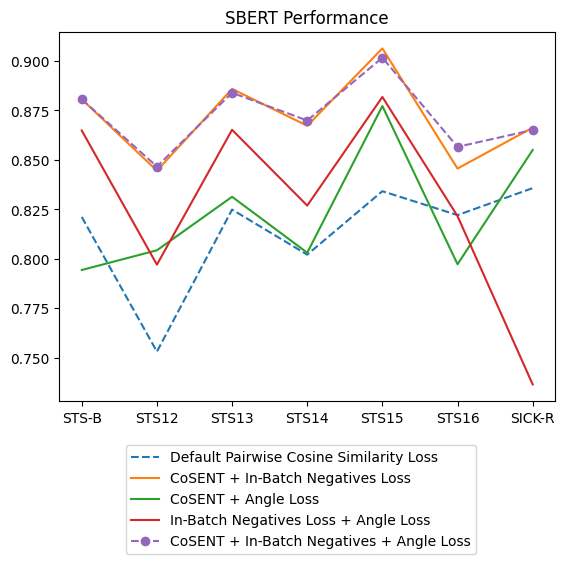

In [ ]:
# SBERT...
plt.plot(datasets_sts, model_wise_df[5]['data'].iloc[1], '--', label='Default Pairwise Cosine Similarity Loss')
plt.plot(datasets_sts, model_wise_df[5]['data'].iloc[5], label='CoSENT + In-Batch Negatives Loss')
plt.plot(datasets_sts, model_wise_df[0]['data'].iloc[6], label='CoSENT + Angle Loss')
plt.plot(datasets_sts, model_wise_df[5]['data'].iloc[7], label='In-Batch Negatives Loss + Angle Loss')
plt.plot(datasets_sts, model_wise_df[5]['data'].iloc[8], 'o--', label='CoSENT + In-Batch Negatives + Angle Loss')
plt.legend(title='Loss Functions')
plt.legend(bbox_to_anchor=(0.12, -0.1), loc='upper left')
plt.title('SBERT Performance')
plt.show()